LOLA enrichment plotted


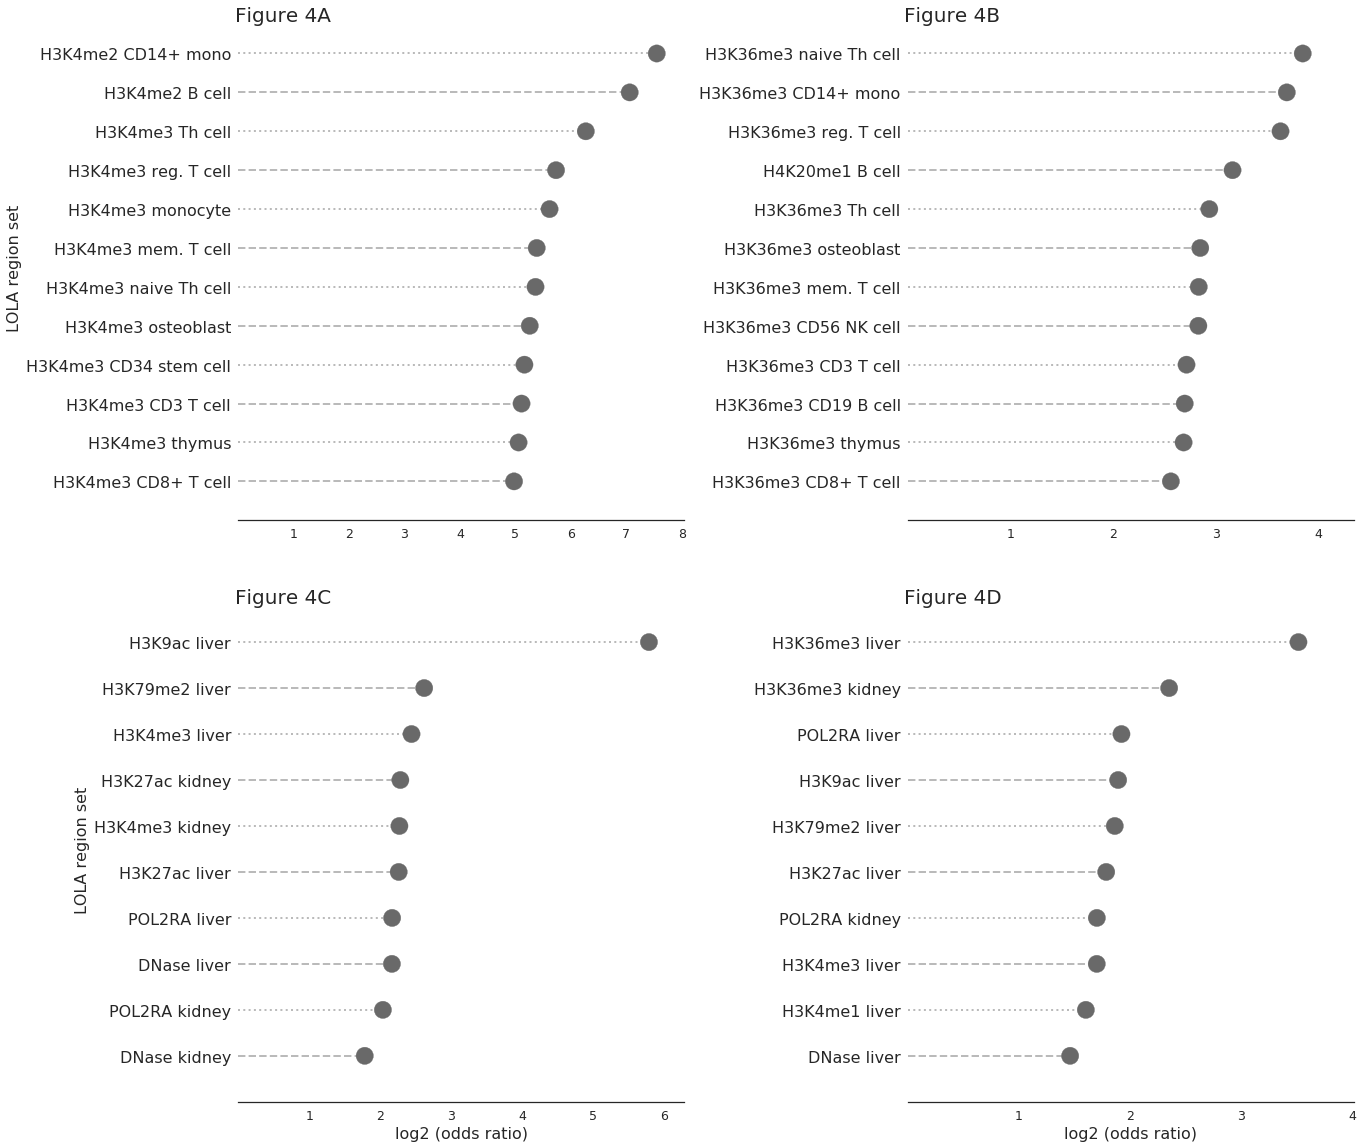

In [1]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

# What is this?
# Plot LOLA enrichment results for top
# marked genes (promoters/bodies) based
# on transferred signal

date = '20180424'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_lola_enrich = True

show_figures = True
save_figures = True

project_base = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies'
supp_folder = os.path.join(project_base, 'supplement')
lola_labels = {'hg19_core': os.path.join(supp_folder, 'lola', 'lola_core_dbset_labels.txt'),
               'hg19_custom': os.path.join(supp_folder, 'lola', 'lola_custom_dbset_labels.txt'),
               'mm9_custom': os.path.join(supp_folder, 'lola', 'lola_custom_dbset_labels.txt')}
fig_folder = os.path.join(project_base, 'figures', 'pub', 'main')

marked_enrich = [('hg19_promoter_custom_ncd4-top-marked-genes_LOLA.tsv', 'main', '4A', 'hg19_custom_prom_ncd4'),
                 ('hg19_body_custom_ncd4-top-marked-genes_LOLA.tsv', 'main', '4B', 'hg19_custom_body_ncd4'),
                 ('mm9_promoter_custom_hepa-top-marked-genes_LOLA.tsv', 'main', '4C', 'mm9_custom_prom_liver'),
                 ('mm9_body_custom_hepa-top-marked-genes_LOLA.tsv', 'main', '4D', 'mm9_custom_body_liver')
                ]

def make_sig_steps(num_tests, measure):
    if measure == 'pValueLog':
        pv = np.array([0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001], dtype=np.float32)
        adj_pv = pv / num_tests
        log_pv = np.log10(adj_pv)
        log_pv *= -1
        pv_labels = ['0.05', '10e-2', '10e-3', '10e-4', '10e-5', '10e-6']
        infos = [(val, lab) for val, lab in zip(log_pv, pv_labels)]
    elif measure == 'qValueLog':
        qv = np.array([10**-3, 10**-6, 10**-9, 10**-12], dtype=np.float32)
        log_qv = np.log10(qv)
        log_qv *= -1
        qv_labels = ['10e-3', '10e-6', '10e-9', '10e-12']
        infos = [(val, lab) for val, lab in zip(log_qv, qv_labels)]
    else:
        raise ValueError('Unexpected measure: {}'.format(measure))
    return infos

sig_steps = make_sig_steps(0, 'qValueLog')

bubble_threshold = [t[0] for t in sig_steps]
bubble_label = [t[1] for t in sig_steps]
bubble_size = [120, 180, 240, 300]
bubble_relation = ['<', '<', '<', '<', '<']

legend_adjust = {'mm9_promoter_custom_unaln-genes_LOLA.tsv': (1.1, 0)}

def exec_lola_enrich(all_enrichments):
    
    plot_params = dict()
    for lola_file, hierarch, fig_key, reg_key in all_enrichments:
        fn = os.path.basename(lola_file)
        
        lola_analysis = fn.split('.')[0]
        lola_analysis = lola_analysis.replace('_LOLA', '')
        records, num_tests = read_enrichments(lola_file)
        label_file = lola_labels[reg_key.rsplit('_', 2)[0]]
        rec_labels = read_regionset_keys(label_file, reg_key)
        if 'mm9' in lola_file:
            spec_color = plot_colors['species']['mouse']['rgb']
            #cmap = make_color_map('mmu_pv', (1, 1, 1), spec_color, 6, False)
            assm = 'mm9'
            species = 'mouse'
        elif 'hg19' in lola_file:
            spec_color = plot_colors['species']['human']['rgb']
            #cmap = make_color_map('hsa_pv', (1, 1, 1), spec_color, 6, False)
            assm = 'hg19'
            species = 'human'
        else:
            raise ValueError(lola_file)
        leg_bb = legend_adjust.get(fn, None)
        plot_params[fig_key] = (records, rec_labels, species, leg_bb)
    
    fig, exart = plot_enrich_bubblechart(plot_params)
    if save_figures:
        outname = 'fig_4A-D_lola_top-marked'

        outpath = os.path.join(fig_folder, 'raw', outname + '.svg')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        
        outpath = os.path.join(fig_folder, 'png', outname + '.png')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        
        outpath = os.path.join(fig_folder, outname + '.pdf')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        
    return True


def read_regionset_keys(fpath, regkey):
    """
    """
    regions = dict()
    found = False
    with open(fpath, 'r') as fh:
        for line in fh:
            if found and line.strip():
                try:
                    k, v = line.strip().split('\t')
                except ValueError:
                    raise ValueError(line)
                if v != '-':
                    regions[k] = v
            elif regkey == line.strip():
                found = True
            elif found and not line.strip():
                break
            else:
                continue
    if not found:
        raise ValueError('No entries for region key {}'.format(regkey))
    return regions


def make_color_map(name, lowest, highest, levels, show=False):
    """
    """
    new_cmap = LinearSegmentedColormap.from_list(name, [lowest, highest], N=levels)
    if show:
        gradient = np.linspace(0, 1, levels)
        gradient = np.vstack((gradient, gradient))
        fig, ax = plt.subplots(nrows=1)
        ax.imshow(gradient, aspect='auto', cmap=new_cmap, interpolation='nearest')
    return new_cmap


def read_enrichments(fpath):
    """
    """
    records = []
    num_tests = 0
    with open(fpath, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for row in rows:
            if any([int(row['b']) == 0, int(row['c']) == 0, int(row['d']) == 0]):
                continue
            num_tests += 1
            if int(row['support']) < 5:
                continue
            # special: unclear what this stuff is, no tissue or cell type specified
            if row['description'] == 'sheffield_dnase':
                assert row['tissue'] == 'NA' and row['cellType'] == 'NA', 'Row contains information: {}'.format(row)
                continue
            if float(row['qValue']) >= 0.05:
                continue
            tmp = {k: row[k] for k in ['logOddsRatio', 'pValueLog', 'description',
                                       'tissue', 'cellType', 'antibody', 'support',
                                       'collection', 'dbSet', 'qValue']}
            tmp['qValueLog'] = -1 * np.log10(float(tmp['qValue']))
            # correct this mistake in the LOLA output
            tmp['OddsRatio'] = tmp['logOddsRatio']
            del tmp['logOddsRatio']
            records.append(tmp)
    df = pd.DataFrame.from_records(records, index='dbSet')
    df = df[['collection', 'OddsRatio', 'qValueLog', 'description', 'cellType', 'tissue', 'antibody']]
    df['OddsRatio'] = df['OddsRatio'].astype(np.float64)
    df['qValueLog'] = df['qValueLog'].astype(np.float64)
    df.sort_values(['OddsRatio', 'qValueLog'], ascending=False, inplace=True)
    filter_out = os.path.basename(fpath)
    filter_out = filter_out.replace('LOLA', 'FILT')
    filter_out = os.path.join(os.path.dirname(fpath), 'filtered', filter_out)
    df.to_csv(filter_out, sep='\t', header=True, index=True, index_label='dbSet',
              columns=['OddsRatio', 'qValueLog', 'cellType', 'tissue',
                       'antibody', 'description', 'collection'])
    records = sorted(records, key=lambda d: float(d['OddsRatio']), reverse=True)
    return records, num_tests


def annotate_items(records, subset):
    """
    """
    xvals = []
    sizes = []
    labels = []
    subrec = sorted([r for r in records if r['dbSet'] in subset],
                    key=lambda d: float(d['OddsRatio']), reverse=True)
    for r in subrec:
        labels.append(subset[r['dbSet']])
        xvals.append(float(r['OddsRatio']))
        qv = float(r['qValueLog'])
        if qv < bubble_threshold[0]:
            sizes.append(bubble_size[0])
        else:
            this_size = None
            for t, s in zip(bubble_threshold[1:-1], bubble_size[1:-1]):
                if qv < t:
                    sizes.append(s)
                    break
            if this_size is None:
                sizes.append(bubble_size[-1])
    xvals = np.array(xvals, dtype=np.float32)
    xvals = np.log2(xvals)
    return xvals, sizes, labels


def plot_enrich_bubblechart(plot_params):
    """
    """
    fig, axes = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)
    axes = axes[0][0], axes[0][1], axes[1][0], axes[1][1]
    
    extra_artists = []
    for fk, ax, step, xl, yl in zip(
                                    sorted(plot_params.keys()),
                                    axes,
                                    [1, 1, 1, 1],
                                    [False, False, True, True],
                                    [True, False, True, False]
                                    ):
        records, labels, species, legbb = plot_params[fk]
    
        x_vals, size_vals, labels = annotate_items(records, labels)
        y_vals = np.arange(0, x_vals.size, 1)[::-1]    
        ax.set_xlim(0, x_vals.max() + 0.5)
        ax.set_ylim(-1, y_vals.size)
    
        ax.scatter(x_vals,
                   y_vals,
                   s=size_vals,
                   c='dimgrey',
                   marker='o',
                   zorder=3)
        
        x_ticks = np.arange(1, np.ceil(x_vals.max()) + 1, step)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_vals)
        ax.set_yticklabels(labels, fontsize=16)

#         leg_patch = []
#         for size, rel, label in zip(bubble_size, bubble_relation, bubble_label):
#             patch = plt.scatter([], [], marker='o', c='dimgrey', s=size,
#                                  label=r'${} $ {}'.format(rel, label))
#             leg_patch.append(patch)

#         leg_qv = ax.legend(handles=leg_patch, loc=4, title='q-value',
#                             fontsize=14)

        a, b = 'dashed', 'dotted'
        x_limit = x_vals.max()
        for x_loc, y_loc in zip(x_vals, y_vals):
            a, b = b, a
            ax.hlines(y=y_loc, xmin=0, xmax=x_loc,
                       colors='darkgrey', linewidths=2,
                       linestyles=a, alpha=0.8)
        if xl:
            ax.set_xlabel('log2 (odds ratio)', fontsize=16)
        if yl:
            ax.set_ylabel('LOLA region set', fontsize=16)
        tt = ax.set_title('Figure {}'.format(fk), fontsize=20)
        tt.set_position([0.1, 0.975])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
    plt.subplots_adjust(hspace=0.15, wspace=0.5)
    return fig, []


if run_lola_enrich:    
    marked_genes = [(os.path.join(supp_folder, 'lola', fn[0]), fn[1], fn[2], fn[3]) for fn in marked_enrich]
    exec_lola_enrich(marked_genes)
    print('LOLA enrichment plotted')